# Exercício sobre transfer learning e ajuste fino de um modelo

Nesse exercício, você irá criar um modelo que detecte se uma foto foi tirada em uma área urbana ou rural. Você poderia construir um novo modelo do zero para esse propósito específico, mas para obter bons resultados, você precisaria de milhares de fotos com rótulos de quais são urbanas e quais são rurais.

Você usará *transfer learning* para treinar um modelo pré-treinado com muito menos dados.

ImageNet é um grande conjunto de dados de imagens, composto por mais de 14 milhões de imagens de milhares de categorias. Keras disponibiliza vários modelos que foram pré-treinados neste conjunto de dados aqui. Um dos modelos é o ResNet.

Você irá adaptar o modelo ResNet50 pré-treinado na base de dados *imagenet* para uma nova tarefa de prever se uma imagem é de uma área rural ou urbana.

Para mais informações sobre o modelo, acesse o link para a documentação da classe: [ResNet50](https://keras.io/api/applications/resnet/#resnet50-function)

**OBS**.: Use o exemplo [transfer_learning.ipynb](https://colab.research.google.com/github/zz4fap/tp557-iot-ml/blob/master/examples/transfer_learning.ipynb) como base para resolver este exercício.

## Importando as bibliotecas

Execute a célula de código abaixo.

Nome: Hyago Vieira Lemes Barbosa Silva

Matrícula: 922

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Pré-processamento dos dados

### Baixe a base de dados

**OBS**.: Como o conjunto de dados é bastante reduzido, usaremos apenas os conjuntos de treinamento e validação. O conjunto de treinamento possui 72 imagens e o de validação apenas 20.

Execute a célula de código abaixo.

In [2]:
_URL = 'https://www.dropbox.com/scl/fi/xfrxie8y8xhie2t9ziz27/rural_urban_dataset.zip?rlkey=c1x7i6pk4q86imm4mcstqn5yk&dl=1'

path_to_zip = tf.keras.utils.get_file('rural_urban_dataset.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'rural_and_urban_photos')
print(PATH)

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

# Mini-batch size.
BATCH_SIZE = 10

# Image size.
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

6450132/6450132 [==============================] - 1s 0us/step
/root/.keras/datasets/rural_and_urban_photos
Found 72 files belonging to 2 classes.


Execute a célula de código abaixo.

In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 20 files belonging to 2 classes.


Exibindo as primeiras nove imagens e rótulos do conjunto de treinamento.

Execute a célula de código abaixo.

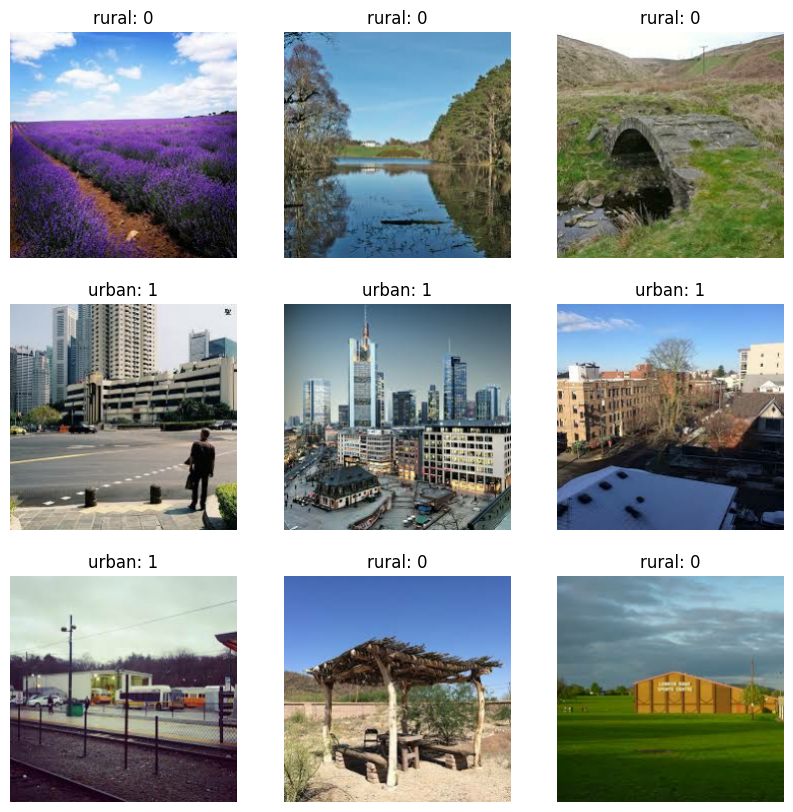

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]]+': '+str(int(labels[i])))
    plt.axis("off")

### Configurando o conjunto de dados para desempenho

Use a pré-busca (i.e., *prefetch*) em buffer para carregar imagens do disco sem bloquear a E/S.

Execute a célula de código abaixo.

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

Aplique transformações aleatórias às imagens de treinamento.

In [6]:
# Digite o código aqui.
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Aplique essas camadas de transformações repetidamente em uma mesma imagem e exiba o resultado.

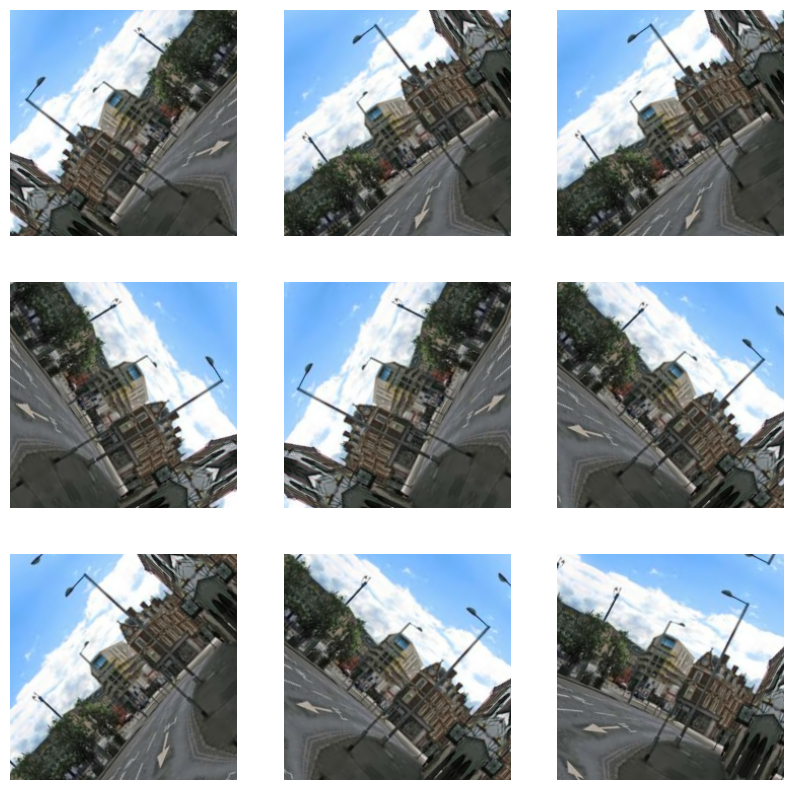

In [9]:
# Digite o código aqui.
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Redimensione os valores de pixel

Use a função `tf.keras.applications.resnet.preprocess_input` para converter as imagens de entrada de RGB para BGR e, em seguida, centralizar cada canal de cores em relação ao conjunto de dados ImageNet, sem dimensionamento.

Para mais informações sobre o modelo, acesse o link para a documentação da classe: [ResNet50](https://keras.io/api/applications/resnet/#resnet50-function)

In [16]:
# Digite o código aqui.
preprocess_input = tf.keras.applications.resnet.preprocess_input

## Crie o modelo base a partir das convnets pré-treinadas

Instancie o modelo ResNet50 com `include_top=False` e `weights='imagenet'`. Lembre-se que o `input_shape` deve ter 3 dimensões.

In [17]:
# Digite o código aqui. escala
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [18]:
# Create the base model from the pre-trained model MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.resnet50.ResNet50(
                                               input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 7, 7, 2048)


## Extração de características

Nesta etapa, você deve congelar a base convolucional do modelo criado na etapa anterior e usá-la como extrator de características. Além disso, você deve adicionar um classificador sobre ele e treiná-lo.

### Congele a base convolucional


In [20]:
# Digite o código aqui.
base_model.trainable = False

### Imprima o resumo do modelo e compare a quantidade de parâmetros treináveis e não treináveis.

In [21]:
# Digite o código aqui.
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

### Adicione uma camada de classificação

Gere predições a partir do bloco de características tomando a média das localizações espaciais usando uma camada `tf.keras.layers.GlobalAveragePooling2D` para converter as características em um vetor.

In [22]:
# Digite o código aqui.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 2048)


Na sequência, crie uma camada `tf.keras.layers.Dense` para converter essas características em uma única predição por imagem. Não precisamos de uma função de ativação aqui porque esta predição será tratada como um `logit`, ou seja, um valor bruto de predição. Os números positivos predizem a classe 1, os números negativos predizem a classe 0.

In [23]:
# Digite o código aqui.
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 1)


Crie o modelo encadeando as camadas de aumento de dados, pré-processamento, modelo base (ResNet50), `global_average_layer` e classificador. Adicione uma camada de `dropout` entre a camada `global_average_layer` e a camada de classificação.

Não se esqueça de fazer `training=False` no modelo base (ResNet50), pois o modelo contém camadas de `BatchNormalization`.

In [24]:
# Digite o código aqui.
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Imprima o resumo do modelo e compare a quantidade de parâmetros treináveis e não treináveis.

In [25]:
# Digite o código aqui.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0     

### Compile o modelo

Compile o modelo antes de treiná-lo. Como existem duas classes, use a perda `tf.keras.losses.BinaryCrossentropy` com `from_logits=True`, pois o modelo fornece uma saída linear (i.e., última camada não tem função de ativação).

**OBS**.: Use um passo de aprendizagem de `0.0001`

In [26]:
# Digite o código aqui.
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

### Treine o modelo

Verifique a acurácia do modelo sem nenhum treinamento no conjunto de validação.

In [27]:
# Digite o código aqui.
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2/2 [==============================] - 2s 45ms/step - loss: 0.6801 - accuracy: 0.6000
initial loss: 0.68
initial accuracy: 0.60


Treine o modelo por 25 épocas. Você deve ver uma acurácia de aproximadamente 90% no conjunto de validação.

In [28]:
initial_epochs = 25

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/25
8/8 [==============================] - 6s 138ms/step - loss: 0.7120 - accuracy: 0.5694 - val_loss: 0.6441 - val_accuracy: 0.6000
Epoch 2/25
8/8 [==============================] - 1s 55ms/step - loss: 0.6042 - accuracy: 0.6806 - val_loss: 0.6079 - val_accuracy: 0.6000
Epoch 3/25
8/8 [==============================] - 1s 56ms/step - loss: 0.6347 - accuracy: 0.6389 - val_loss: 0.5748 - val_accuracy: 0.6500
Epoch 4/25
8/8 [==============================] - 1s 57ms/step - loss: 0.6060 - accuracy: 0.7500 - val_loss: 0.5468 - val_accuracy: 0.6500
Epoch 5/25
8/8 [==============================] - 1s 57ms/step - loss: 0.5007 - accuracy: 0.8194 - val_loss: 0.5208 - val_accuracy: 0.6500
Epoch 6/25
8/8 [==============================] - 1s 56ms/step - loss: 0.5042 - accuracy: 0.7639 - val_loss: 0.4950 - val_accuracy: 0.7000
Epoch 7/25
8/8 [==============================] - 1s 56ms/step - loss: 0.4538 - accuracy: 0.7917 - val_loss: 0.4758 - val_accuracy: 0.7500
Epoch 8/25
8/8 [==========

### Plote as curvas de aprendizado

Analise as curvas de aprendizado da acurácia/perda de treinamento e validação ao usar o modelo base ResNet50 como um extrator de características.

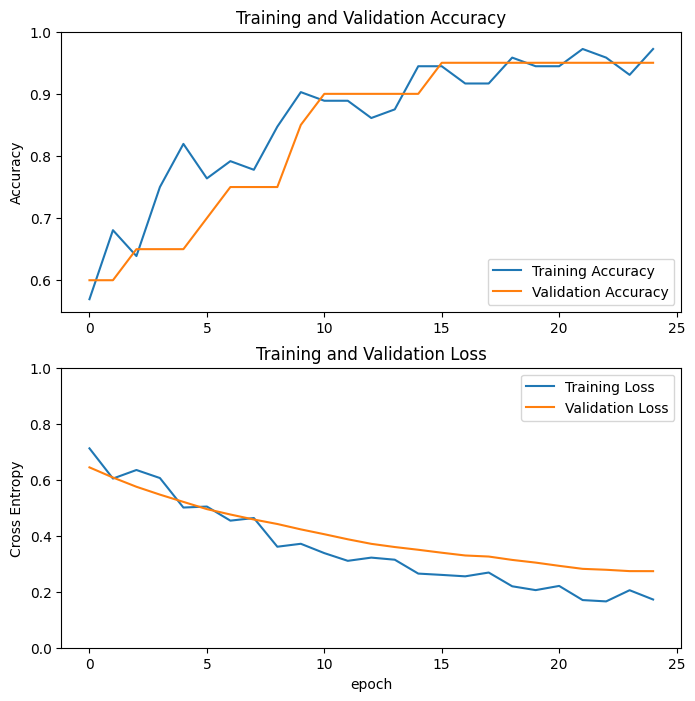

In [29]:
# Digite o código aqui.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Faça o ajuste fino do modelo


### Descongele as camadas superiores do modelo

Tudo o que você precisa fazer é descongelar o modelo base e definir as camadas inferiores como não treináveis. Em seguida, você deve recompilar o modelo (necessário para que essas alterações tenham efeito) e retomar o treinamento.

### Descongele o modelo base.

In [30]:
# Digite o código aqui.
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))



Number of layers in the base model:  175


### Congele apenas as 100 primeiras camadas do modelo base.

In [31]:
# Digite o código aqui.
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compile o modelo

Como você está treinando um modelo muito maior e deseja reajustar os pesos pré-treinados, é importante utilizar uma taxa de aprendizado menor nesta fase. Caso contrário, o modelo poderá se ajustar muito rapidamente.

**OBS**.: Use um passo de aprendizagem 10 vezes menor do que o usado anteriormente.

In [32]:
# Digite o código aqui.
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

### Imprima o resumo do modelo e compare a quantidade de parâmetros treináveis e não treináveis.

In [33]:
# Digite o código aqui.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0     

### Continue o treinamento do modelo

Esta etapa deve melhorar a acurácia do modelo em alguns pontos percentuais.

**OBS**.: Faça o ajuste fine do modelo por 15 épocas.

In [34]:
# Digite o código aqui.
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

print('total_epochs:', total_epochs)

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

total_epochs: 40
Epoch 25/40
8/8 [==============================] - 20s 270ms/step - loss: 0.1298 - accuracy: 0.9722 - val_loss: 0.1163 - val_accuracy: 1.0000
Epoch 26/40
8/8 [==============================] - 1s 83ms/step - loss: 0.0262 - accuracy: 1.0000 - val_loss: 0.1169 - val_accuracy: 1.0000
Epoch 27/40
8/8 [==============================] - 1s 85ms/step - loss: 0.0661 - accuracy: 0.9583 - val_loss: 0.0685 - val_accuracy: 1.0000
Epoch 28/40
8/8 [==============================] - 1s 84ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.0579 - val_accuracy: 1.0000
Epoch 29/40
8/8 [==============================] - 1s 85ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 1.0000
Epoch 30/40
8/8 [==============================] - 1s 85ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0504 - val_accuracy: 1.0000
Epoch 31/40
8/8 [==============================] - 1s 85ms/step - loss: 0.0173 - accuracy: 0.9861 - val_loss: 0.0474 - val_accuracy: 1.0000
E

### Plote as curvas de aprendizado

Analise as curvas de aprendizado da acurácia/perda de treinamento e validação ao usar o modelo base ResNet50 como um extrator de características.

Após o ajuste fino, o modelo deve atingir mais de 98% de acurácia no conjunto de validação.

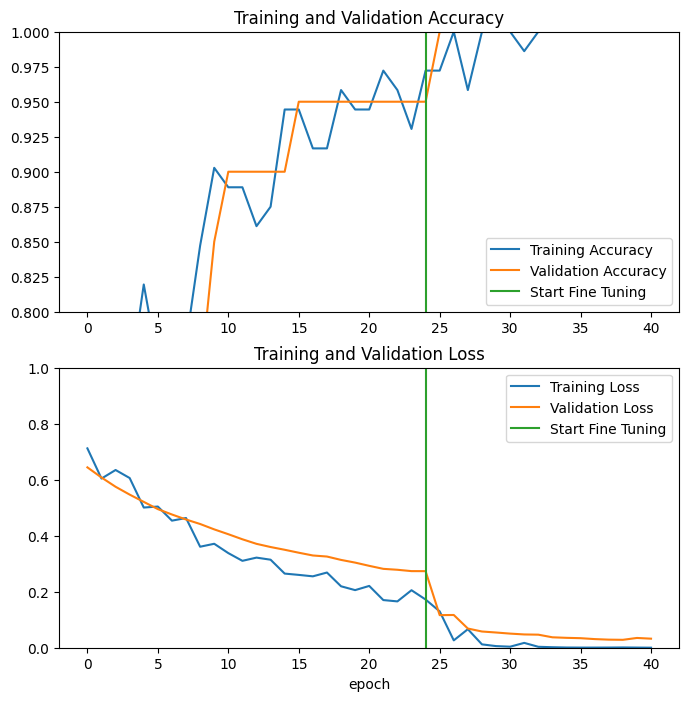

In [35]:
# Digite o código aqui.
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Avalie e faça predições com o modelo

Verifique o desempenho do modelo nos dados do conjunto de validação usando o método `evaluate`.

In [39]:
# Digite o código aqui.

loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 0s 71ms/step - loss: 0.0323 - accuracy: 1.0000
Test accuracy : 1.0


### Exiba algumas imagens do conjunto de validação juntamente com a classe que foi atribuída a ela.

Predictions:
 [0 0 1 0 1 0 1 0 0 0]
Labels:
 [0 0 1 0 1 0 1 0 0 0]


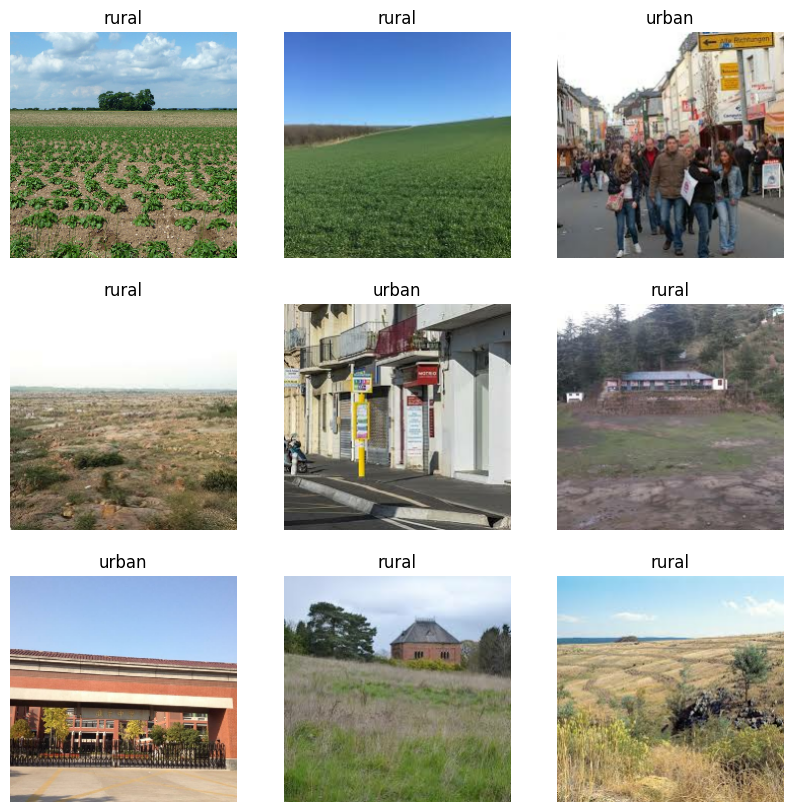

In [40]:
# Digite o código aqui.

# Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

### Após análisar os resultados gerados pelo novo modelo, o que você pode concluir?

**Resposta**
Após o treinamento com ajuste fino, o modelo ficou muito bom, e basicamente decorou tudo, pois tanto a acurácia quanto a validação foram com valores 1, e ficaram excelentes, mesmo sendo parecido que é bom, podemos analisar que certamente se talves pegarmos alguma imagem nova, que não foi colocar aqui, ele pode ter um valor a ser surpreendido, memso sendo um modelo bom, mas não se aconçelha deixar o valor no chegar nos 100% pois não é algo real, isto não existe para uma máquina isto não é bom ela tem que generalizar e não decorar.